# Infection spreading simulation

## Data analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

In [2]:
flights_data = pd.read_csv("./2008.csv")
flights_data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


Посмотрим, есть ли пустые столбцы

In [3]:
flights_data.isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

Подготовим описание признаков

In [4]:
flights_data.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

1) **<u>Year</u>, <u>Month</u>, <u>DayofMonth</u>, DayOfWeek** - год, месяц, день месяца, день недели  
2) **DepTime (Departure Time), ArrTime (Arrival Time), <u>CRSDepTime</u>, <u>CRSArrTime</u>, ActualElapsedTime, CRSElapsedTime, AirTime** - время отправления, время прибытия, запланированное время отправления, запланированное время посадки, фактическое время полета, запланированное время полета, время в воздухе  
3) **DepDelay (Departure Delay), ArrDelay (Arrival Delay), CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay** - задержка отправления, задержка прибытия, задержка рейса, задержка из-за погоды, задержка из-за Национальной системы воздушного простанства (NAS), задержка для обеспечения безопасности, задержка самолета  
4) **Distance** - расстояние (в милях)  
5) **UniqueCarrier** - код авиакомпании  
6) **<u>Origin</u>, <u>Dest (Destination)</u>** - код аэропорта отправления, код аэропорта прибытия  
7) **<u>Cancelled</u>, CancellationCode** - отмена рейса, код отмены  
8) **TaxiIn, TaxiOut** - время самолета на полосе при прибытии, время самолета на полосе при отправлении  

Будем использовать только подчернутные столбцы

In [5]:
target_columns = [
    "Year",
    "Month",
    "DayofMonth",
    "CRSDepTime",
    "CRSArrTime",
    "Origin",
    "Dest",
    "Cancelled"
]

Посмотрим, какой тип имеют целевые признаки

In [6]:
flights_data[target_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 8 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Year        int64 
 1   Month       int64 
 2   DayofMonth  int64 
 3   CRSDepTime  int64 
 4   CRSArrTime  int64 
 5   Origin      object
 6   Dest        object
 7   Cancelled   int64 
dtypes: int64(6), object(2)
memory usage: 427.8+ MB


Попробуем разобраться, в каком формате нам дано время

In [7]:
flights_data[["CRSDepTime", "CRSArrTime"]].describe()

,CRSDepTime,CRSArrTime
count,7.009728e+06,7.009728e+06
mean,1.326086e+03,1.494801e+03
std,4.642509e+02,4.826728e+02
min,0.000000e+00,0.000000e+00
25%,9.250000e+02,1.115000e+03
50%,1.320000e+03,1.517000e+03
75%,1.715000e+03,1.907000e+03
max,2.359000e+03,2.400000e+03


Похоже, что время записано в таком формате: 2400 --> 24:00

## Data prepare

В данных указаны только коды аэропортов, добавим больше информации  
https://github.com/lxndrblz/Airports/blob/main/airports.csv  

In [8]:
airports_details = pd.read_csv("./airports.csv")
airports_details.head()

,code,time_zone_id,name,city_code,country_id,location,elevation,url,icao,city,county,state
0,UGL,Antarctica/South_Pole,Union Glacier Blue-Ice Runway,UGL,AQ,POINT (-83.320833 -79.777778),2461,NaN,SCGC,NaN,NaN,NaN
1,SXW,Pacific/Port_Moresby,Sauren,SXW,PG,POINT (148.95305 -5.971389),177,NaN,AYSV,NaN,NaN,NaN
2,NDV,America/New_York,USN Heliport,NDV,US,POINT (-77 38.86667),19,NaN,NaN,NaN,NaN,NaN
3,EAP,Europe/Zurich,EuroAirport Basel-Mulhouse-Freiburg Airport,EAP,CH,POINT (7.529167 47.59),846,NaN,NaN,Basel,NaN,NaN
4,NET,America/Nassau,New Bight,NET,BS,POINT (-75.45763803663925 24.314824100000003),36,NaN,NaN,NaN,NaN,NaN


In [9]:
# Добавим информацию об аэропорте отправления
temp = flights_data.merge(airports_details, left_on="Origin", right_on="code", how="inner")

# Проверим, что все сопоставилось
if temp.shape[0] == flights_data.shape[0]:
    print("Origin name added successfully")
else:
    print("Detected not matched data")
    
# Сохраним только нужное
target_columns += ["OriginName"]
temp = temp.rename(columns={"name": "OriginName"})
temp = temp[target_columns]

# Добавим информацию об аэропорте прибытия
temp = temp.merge(airports_details, left_on="Dest", right_on="code", how="inner")

# Снова проверим, что все сопоставилось
if temp.shape[0] == flights_data.shape[0]:
    print("Dest name added successfully")
else:
    print("Detected not matched data")
    
# Снова сохраним только нужное
target_columns += ["DestName"]
temp = temp.rename(columns={"name": "DestName"})
temp = temp[target_columns]

temp.head()

Origin name added successfully
Dest name added successfully


,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Origin,Dest,Cancelled,OriginName,DestName
0,2008,1,3,1955,2225,IAD,TPA,0,Washington Dulles International Airport,Tampa International Airport
1,2008,1,3,735,1000,IAD,TPA,0,Washington Dulles International Airport,Tampa International Airport
2,2008,1,4,1955,2225,IAD,TPA,0,Washington Dulles International Airport,Tampa International Airport
3,2008,1,4,735,1000,IAD,TPA,0,Washington Dulles International Airport,Tampa International Airport
4,2008,1,5,1955,2225,IAD,TPA,0,Washington Dulles International Airport,Tampa International Airport


In [10]:
flights_data = temp

Напишем функции конвертации времени в формат `datetime` и обработаем весь датасет

In [11]:
def preprocess(df):
    # Заменим 24:00 на 23:59, чтобы ничего не ломалось
    df.loc[df["CRSDepTime"] >= 2400, "CRSDepTime"] = 2359
    df.loc[df["CRSArrTime"] >= 2400, "CRSArrTime"] = 2359
    
    # Создадим временные столбцы для хранения преобразованных строк со временем
    df["dep_time"] = df["CRSDepTime"].apply(to_time)
    df["arr_time"] = df["CRSArrTime"].apply(to_time)
    
    # Создадим столбцы для хранения даты в формате datetime
    df["dep_datetime"] = to_datetime(df["Year"], df["Month"], df["DayofMonth"], df["dep_time"])
    df["arr_datetime"] = to_datetime(df["Year"], df["Month"], df["DayofMonth"], df["arr_time"])

    # Оставляем только нужные столбцы
    columns = [
        "Origin",
        "OriginName",
        "Destination",
        "DestinationName",
        "DepartureTime",
        "ArrivalTime",
        "Cancelled",
    ]
    df = df.rename(columns={"dep_datetime": "DepartureTime"})
    df = df.rename(columns={"arr_datetime": "ArrivalTime"})
    df = df.rename(columns={"Dest": "Destination", "DestName": "DestinationName"})
    result = df[columns]
    
    # Скорректируем время межсуточных перелетов
    result.loc[result["DepartureTime"] > result["ArrivalTime"], "ArrivalTime"] += timedelta(hours=24)

    # Отсортируем по дате отправления
    result.sort_values("DepartureTime", inplace=True)
    
    return result
    
def to_time(int_repr: int):
    str_repr = str(int_repr).rjust(4, "0")
    
    if not (0 <= int(str_repr[:2]) <= 23):
        raise Exception("The hours value can only be in the range of 0 to 23")
        
    if not (0 <= int(str_repr[2:]) <= 59):
        raise Exception("The minutes value can only be in the range of 0 to 59")
    
    return str_repr[:2] + ':' + str_repr[2:]

@np.vectorize
def to_datetime(year: int, month: int, day: int, time: str):
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m))
    return result

# Протестируем работу функций
a = to_datetime(2023, 9, 18, "21:05")
print(a)
b = to_time(23)
print(b)

2023-09-18 21:05:00
00:23


In [12]:
df = preprocess(flights_data)
df.head()

C:\Users\mikhail.klyazhev\AppData\Local\Temp\ipykernel_1840\2015156425.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.sort_values("DepartureTime", inplace=True)


,Origin,OriginName,Destination,DestinationName,DepartureTime,ArrivalTime,Cancelled
1710074,LAX,Los Angeles International Airport,DTW,Detroit Metropolitan Wayne County Airport,2008-01-01 00:10:00,2008-01-01 07:37:00,0
5078487,SMF,Sacramento International Airport,JFK,John F. Kennedy International Airport,2008-01-01 00:15:00,2008-01-01 08:23:00,0
4831500,SMF,Sacramento International Airport,DFW,Dallas/Fort Worth International Airport,2008-01-01 00:25:00,2008-01-01 05:35:00,0
5054951,PHX,Phoenix Sky Harbor International Airport,JFK,John F. Kennedy International Airport,2008-01-01 00:25:00,2008-01-01 07:09:00,0
3465786,ANC,Ted Stevens Anchorage International Airport,SEA,Seattle-Tacoma International Airport,2008-01-01 00:30:00,2008-01-01 04:44:00,0


## Simulation

Создадим класс модели симуляции распространения болезни

In [13]:
class SusceptibleInfectedModel():
    def __init__(self, data: pd.DataFrame, infect_proba=0.5):
        self.infect_proba = infect_proba
        self.data = data
        self.simulation_results = None
        self.graph = None

    def simulation(self, start_point: str, start_date: datetime):
        infected_points = [start_point]
        self.simulation_results = {start_point: start_date}
        df = self.data

        for row in df.itertuples():
            chance = np.random.uniform()
            # Проверяем, что пункт отправления заражен, пункт назначения не заражен, рейс не отменяли и есть ли шанс не заразиться
            if (row.Origin in infected_points) \
            and (row.Destination not in infected_points)\
            and (row.Cancelled == 0)\
            and (chance <= self.infect_proba):
                # Проверяем, что вылет был после времени заражения пункта отправления
                if self.simulation_results[row.Origin] > row.DepartureTime:
                    continue
                # Добавляем зараженный пункт
                infected_points.append(row.Destination)
                self.simulation_results[row.Destination] = row.ArrivalTime
            else:
                continue

        return self.simulation_results
    
    def save_simulation_results(self, save_path):
        simulation_results = pd.DataFrame.from_dict(self.simulation_results, orient="index").reset_index()
        simulation_results.columns = ["Point", "InfectedDate"]
        simulation_results["InfectionProbability"] = self.infect_proba
        results = pd.concat([results, simulation_results])
        results.to_pickle(f"{save_path}.pkl")

Посмотрим на симуляцию распространения болезни с низкой степенью заражения

In [14]:
N = len(df["Origin"].unique())
p = 0.01
airport = "ABE"
doomsday = datetime(2008, 1, 1, 0, 0)
print(f"Start point: {airport}, Doomsday: {doomsday}")

np.random.seed(42)
sim_model = SusceptibleInfectedModel(df, p)
res = sim_model.simulation(airport, doomsday)
print(f"Infected points: {len(res)}/{N}")

Start point: ABE, Doomsday: 2008-01-01 00:00:00
Infected points: 297/303


Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоним по 10 симуляций распространения

In [15]:
def run_simulations(df, point, date, probs, n_iter):
    results = pd.DataFrame(columns=["InfectionProbability", "SimID", "Point", "InfectedDate"])
    sim_model = SusceptibleInfectedModel(df)
    for p in probs:
        print(f"Simulations for p = {p}")
        sim_model.infect_proba = p
        for i in tqdm(range(n_iter)):
            sim_res = pd.DataFrame.from_dict(sim_model.simulation(point, date), orient='index').reset_index()
            sim_res.columns = ["Point", "InfectedDate"]
            sim_res["SimID"] = i
            sim_res["InfectionProbability"] = p
            results = pd.concat([results, sim_res])
    return results

In [16]:
airport = "ABE"
doomsday = datetime(2008, 1, 1, 0, 0)
probs = [0.01, 0.05, 0.1, 0.5, 1]
n_sim = 10

np.random.seed(42)
print(f"Start point: {airport}, Doomsday: {doomsday}")
results_df = run_simulations(df, airport, doomsday, probs, n_sim)
results_df.to_pickle('results.pkl')

Start point: ABE, Doomsday: 2008-01-01 00:00:00
Simulations for p = 0.01


100%|██████████| 10/10 [06:23<00:00, 38.35s/it]


Simulations for p = 0.05


100%|██████████| 10/10 [07:04<00:00, 42.49s/it]


Simulations for p = 0.1


100%|██████████| 10/10 [07:21<00:00, 44.13s/it]


Simulations for p = 0.5


100%|██████████| 10/10 [07:28<00:00, 44.88s/it]


Simulations for p = 1


100%|██████████| 10/10 [07:57<00:00, 47.77s/it]


Рассчитаем для каждых 12 часов симуляции, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени

In [17]:
# Временные границы данных
min_time = df["DepartureTime"].min()
max_time = df["ArrivalTime"].max()
print(f"The inffection spread from {min_time} to {max_time}")

# Временной шаг для расчета
td = timedelta(hours=12)

# Начало отсчета
tp = min_time

# Словарь для хранения
tsim_res = dict()

while tp < max_time:
    infected_pct = results_df[results_df.InfectedDate <= tp].groupby(["InfectionProbability", "SimID"]).size()/N
    infected_pct = infected_pct.reset_index().groupby("InfectionProbability")[0].mean()
    tsim_res[tp] = infected_pct
    tp += td

The inffection spread from 2008-01-01 00:10:00 to 2009-01-01 21:36:00


Построим графики числа зараженных городов в зависимости от времени для каждой из вероятностей

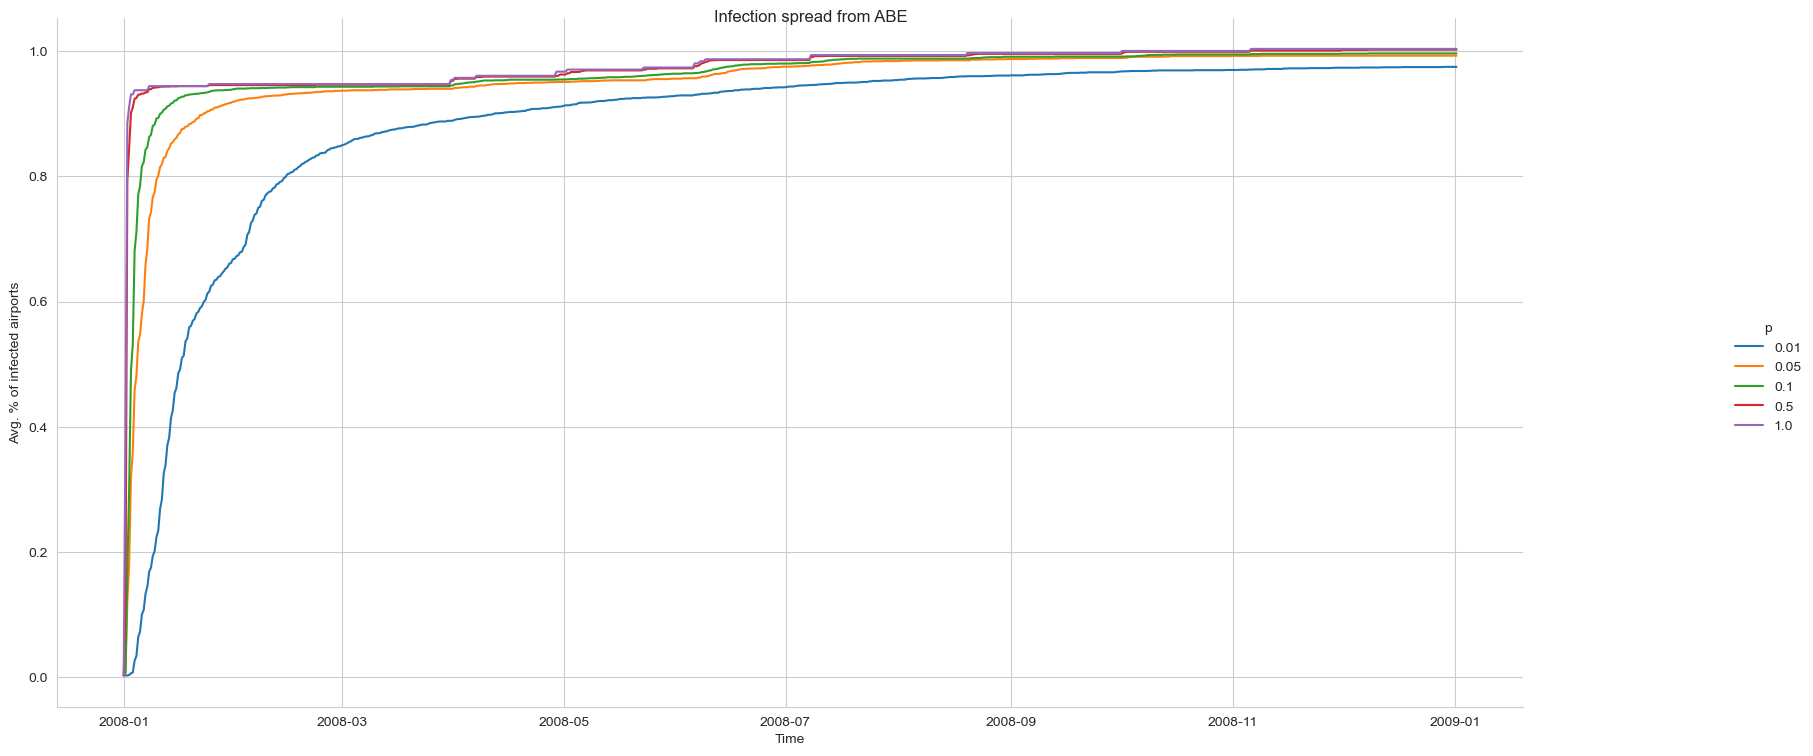

In [18]:
# Создадим датафрейм для визуализации
data_viz = pd.DataFrame.from_dict(tsim_res, orient="index")
data_viz = data_viz.reset_index().melt(id_vars="index", var_name="p")
data_viz["p"] = data_viz.p.astype("category")

# Визуализация
sns.set_style("whitegrid")
lp = sns.relplot(data=data_viz, kind="line", x="index", y="value", hue="p")
lp.fig.set_figwidth(20)
lp.fig.set_figheight(8)
lp.fig.suptitle(f"Infection spread from {airport}")
lp.ax.set_xlabel("Time")
lp.ax.set_ylabel("Avg. % of infected airports")
plt.show()

Даже при низкой степени заражения болезни распростроняется достаточно быстро и за год заражены будут все. В первые 3 месяца болезнь захватывает более 80% аэропортов.  

## Work with graph

Построим ненаправленный взвешенный граф

In [19]:
@np.vectorize
def points_to_alphabetical_order(point_from, point_to):
    if point_from < point_to:
        result = f"{point_from} {point_to}"
    else:
        result = f"{point_to} {point_from}"
    return result

In [20]:
# Количество перелетов
flights_num = df.shape[0]

# Сохраним ребра графа в виде датасета
df["Edge"] = points_to_alphabetical_order(df.Origin, df.Destination)
# Рассчитаем веса ребер
graph_edges = df.groupby("Edge").size() / flights_num
graph_edges = graph_edges.reset_index()
graph_edges[["Node1", "Node2"]] = graph_edges["Edge"].str.split(" ", 1, expand=True)
graph_edges = graph_edges[["Node1", "Node2", 0]]
graph_edges.columns = ["Node1", "Node2", "Weight"]
# Сохраним для последующего чтения
graph_edges.to_csv("graph_edges.csv", header=False, index=False, sep=" ")
graph_edges.head()

,Node1,Node2,Weight
0,ABE,ATL,2.432334e-04
1,ABE,BHM,1.426589e-07
2,ABE,CLE,2.296808e-04
3,ABE,CLT,1.326728e-04
4,ABE,CVG,7.061615e-05


In [21]:
# Создадим граф
graph = nx.read_weighted_edgelist("graph_edges.csv", nodetype=str)
print(f"{graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges in the graph")

305 nodes and 2834 edges in the graph


Отобразим граф

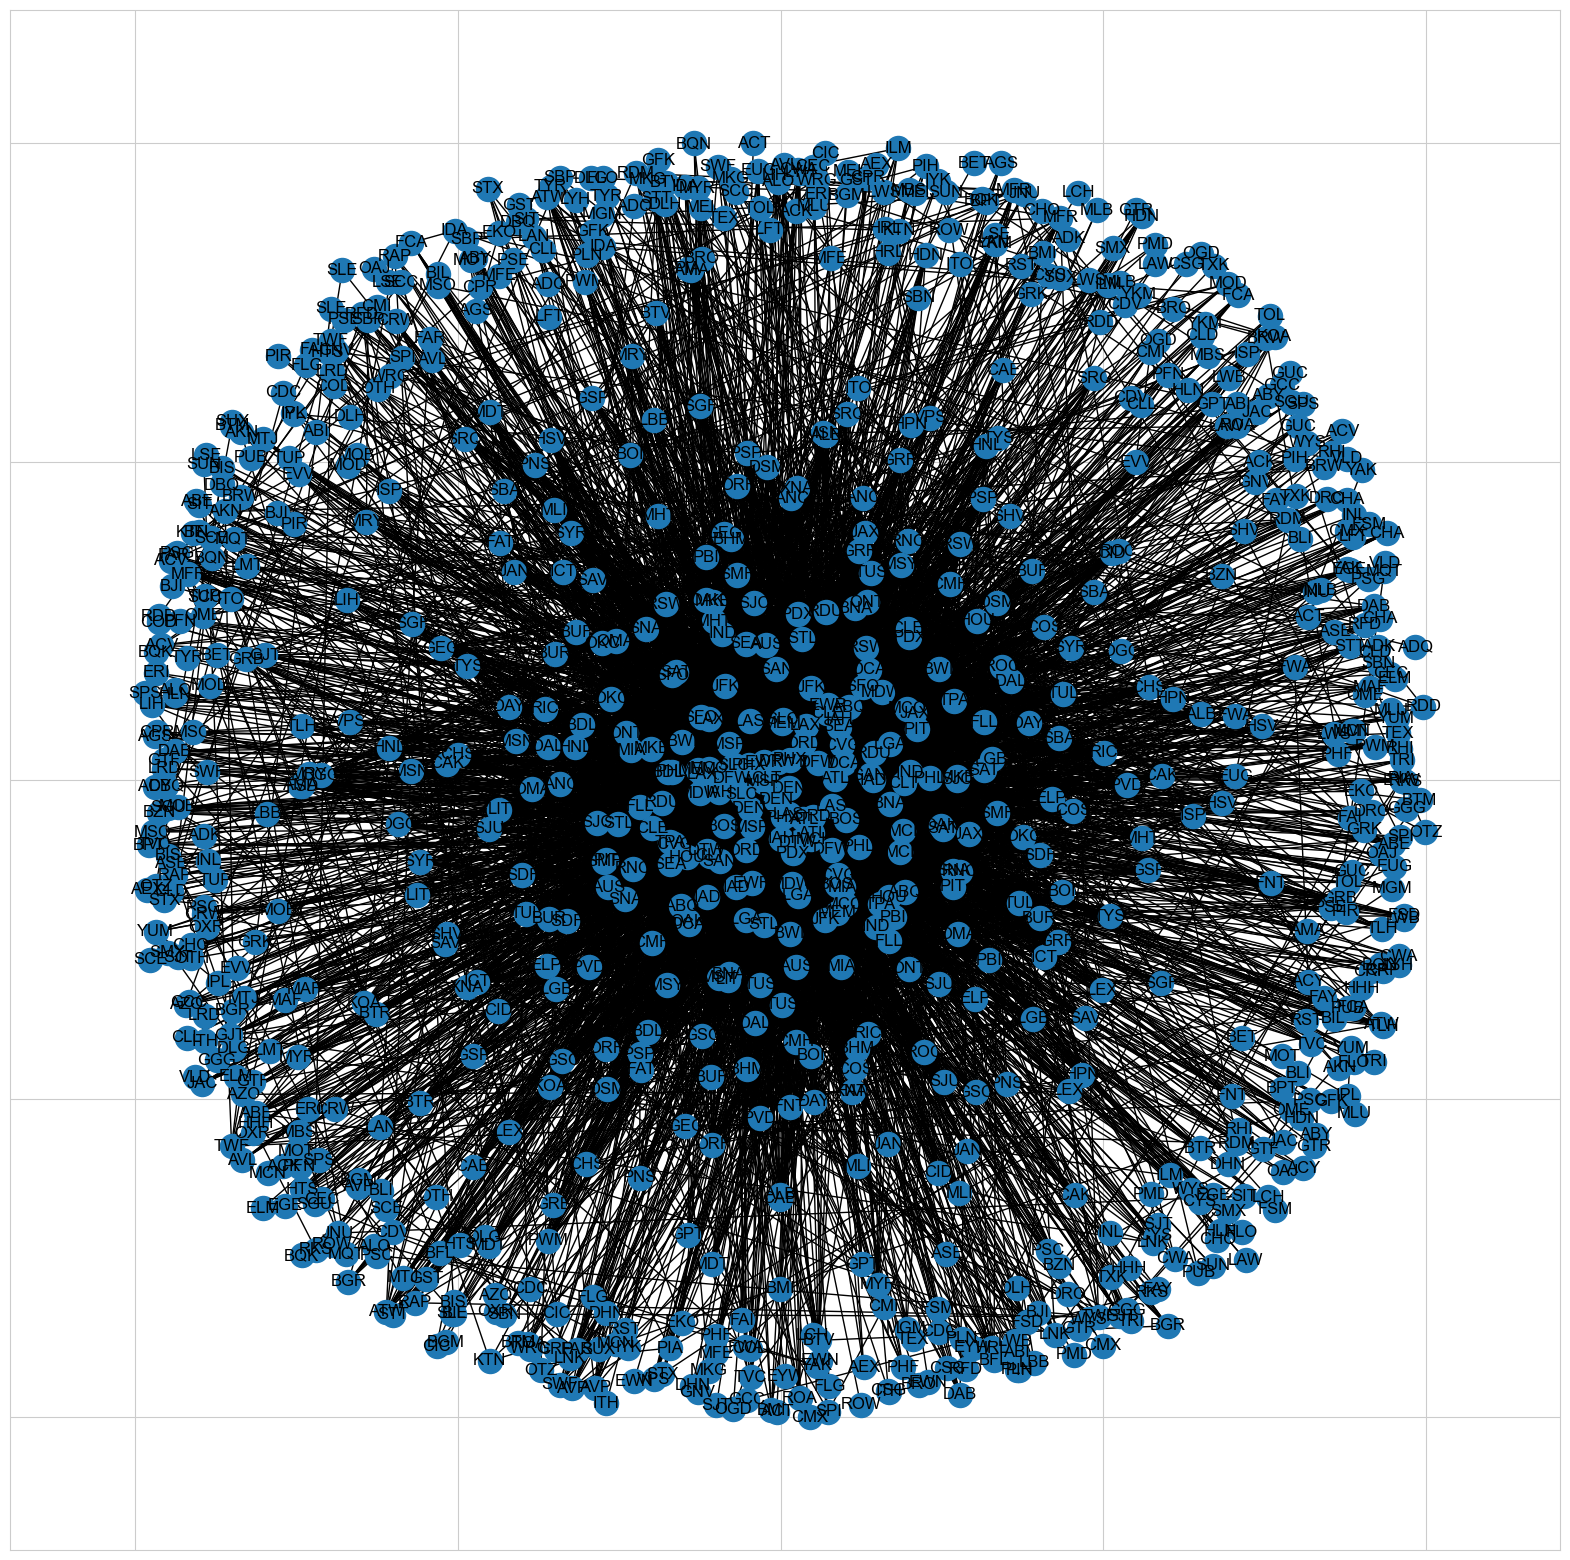

In [24]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(graph)
plt.show()

Посчитаем метрики для каждой ноды графа

In [25]:
clustering = nx.clustering(graph, weight='weight')
degree = dict(graph.degree(weight='weight'))
centrality = nx.betweenness_centrality(graph, weight='weight')

Сохраним метрики в датафрейм

In [26]:
node_metrics = pd.DataFrame.from_dict(clustering ,orient="index", columns=["Clustering"]).join([
    pd.DataFrame.from_dict(degree ,orient="index", columns=["Degree"]),
    pd.DataFrame.from_dict(centrality ,orient="index", columns=["Centrality"])
])
node_metrics.head()

,Clustering,Degree,Centrality
ABE,0.025966,0.001370,0.001032
ATL,0.022777,0.118269,0.127454
BHM,0.042371,0.006756,0.020993
CLE,0.033988,0.018772,0.000000
CLT,0.042964,0.035961,0.044871


Посмотрим на метрики по убыванию коэффициента кластеризации

In [27]:
node_metrics.sort_values("Clustering", ascending=False).head()

,Clustering,Degree,Centrality
LFT,0.178200,0.001392,0.0
LAW,0.157279,0.000675,0.0
ITO,0.141637,0.002297,0.0
GRK,0.139439,0.001065,0.0
LSE,0.137243,0.000572,0.0


Посмотрим на статистики метрик

In [28]:
node_metrics.describe()

,Clustering,Degree,Centrality
count,305.000000,3.050000e+02,305.000000
mean,0.039208,6.557377e-03,0.017303
std,0.033406,1.436104e-02,0.035015
min,0.000000,2.853178e-07,0.000000
25%,0.011779,3.684879e-04,0.000000
50%,0.036350,1.211745e-03,0.000000
75%,0.057230,4.621863e-03,0.018181
max,0.178200,1.182691e-01,0.208582


Теперь прогоним симуляцию 50 раз и посчитаем медианное время до заражения

In [29]:
np.random.seed(42)
results_50 = run_simulations(df, airport, doomsday, [0.5], 50)
results_50.to_pickle("50_sim_res.pkl")

Simulations for p = 0.5


100%|██████████| 50/50 [39:42<00:00, 47.65s/it]


In [30]:
results_50 = results_50.reset_index(drop=True)
# Время начала распространения инфекции
start_time = results_50.loc[0, "InfectedDate"]
# Посчитаем время между началом распространения и заражением для каждого аэропорта
results_50["UntilInfection_sec"] = results_50["InfectedDate"] - start_time
# Посчитаем медианное время
median_time = results_50.groupby("Point")["UntilInfection_sec"].median()

In [31]:
# Добавим медианное время к вершинам графа
node_metrics = node_metrics.join(median_time)
# Преобразуем время до заражения в часы
node_metrics["UntilInfection_hours"] = node_metrics["UntilInfection_sec"].dt.seconds / 3600
node_metrics.head()

,Clustering,Degree,Centrality,UntilInfection_sec,UntilInfection_hours
ABE,0.025966,0.001370,0.001032,0 days 00:00:00,0.000000
ATL,0.022777,0.118269,0.127454,0 days 11:51:00,11.850000
BHM,0.042371,0.006756,0.020993,0 days 13:35:00,13.583333
CLE,0.033988,0.018772,0.000000,0 days 13:39:30,13.658333
CLT,0.042964,0.035961,0.044871,0 days 10:26:00,10.433333


Визуализируем полученные метрики и посчитаем коэффициент корреляции Спирмана

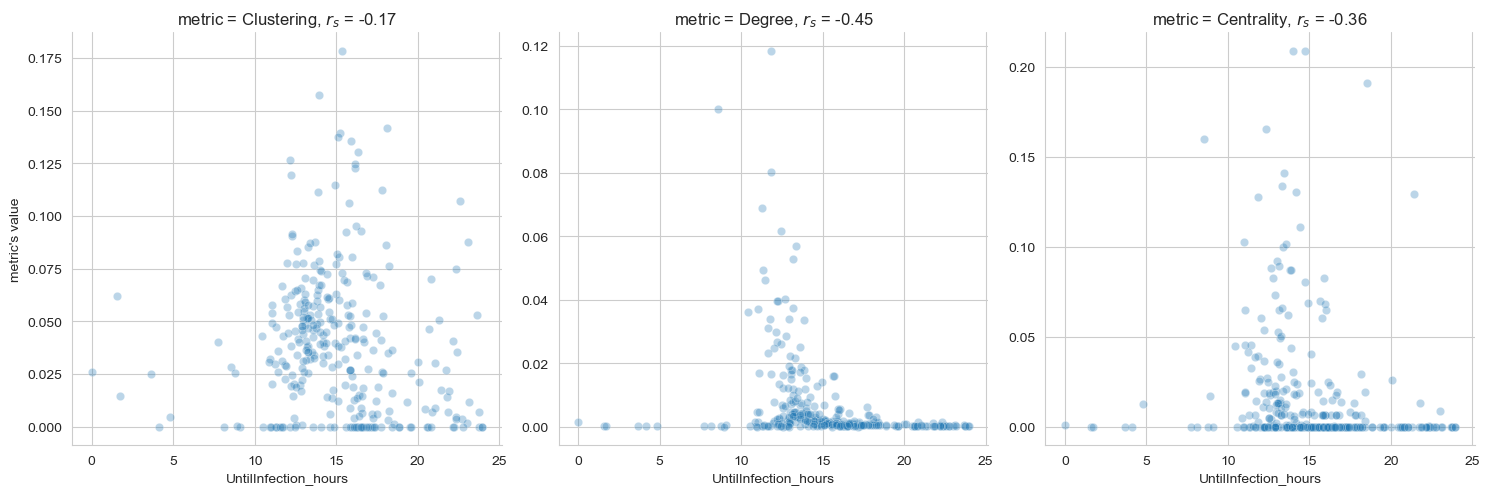

In [32]:
scorr = node_metrics.drop("UntilInfection_sec", axis=1).corr("spearman").loc["UntilInfection_hours"]
viz = node_metrics.drop("UntilInfection_sec", axis=1).reset_index().melt(id_vars=["index", "UntilInfection_hours"], var_name="metric")

sns.set_style("whitegrid")
sp = sns.relplot(data=viz, x="UntilInfection_hours", y="value", col="metric", facet_kws={"sharey": False, "sharex": True}, alpha=0.3)
sp.set_ylabels("metric's value")
axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f"{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}"
    ax.set_title(title)
plt.show()

**Коэффициент кластеризации (clustering)**  
Коэффициент кластеризации - это мера степени, в которой узлы графа имеют тенденцию к объединению в кластеры. Обычно он определяется как доля пар соседей узла, которые также связаны друг с другом. Для взвешенных графов существует несколько способов определения кластеризации. Используемый здесь способ определяется как среднее геометрическое весов ребер подграфа.

Здесь мы наблюдаем слабую отрицательную корреляцию (Clustering = -0.17) между кластеризацией и временем заражения - это может означать, что в тех областях графа, где кластеризация выше, распространение болезни может происходить медленнее. Аэропорты с более высоким коэффициентом кластеризации заражаются позже, чем с более низким. Одна из возможных причин этого может заключаться в том, что между аэропортами внутри кластера выполняется много рейсов, но относительно меньше рейсов в аэропорты за пределами кластера. Это затрудняет распространение инфекции по территории кластера и ее попадание в рассматриваемый аэропорт, если она находится за пределами группы.  

**Центральность кратчайшего пути (centrality)**  
Для каждой пары вершин в связном графе существует хотя бы один кратчайший путь между ними. Центральность между вершинами - это количество кратчайших путей, проходящих через вершину.

Мы видим отрицательную корреляцию (Centrality = -0.45) со временем заражения. Это может быть связано с тем, что через аэропорты с более высокой связностью, скорее всего, проходит больше рейсов, что обеспечивает множество путей для распространения инфекции. Кроме того, если узел занимает центральное положение в сети, то он с большей вероятностью будет связан с другими зараженными узлами и, следовательно, с большей вероятностью будет заражен по мере развития моделирования.  

**Степень (degree)**  
Это мера количества связей узла с другими узлами, для взвешенного графа она рассчитывается как сумма весов ребер, смежных с узлом.

Отрицательная корреляция (Degree = -0.36) между степенью и медианным временем заражения в симуляции говорит о том, что количество связей узла оказывает влияние на время, необходимое для заражения аэропорта. Это может объясняться тем, что распространению инфекции в сети увеличивается с увеличением количества связей между узлами.  